<a href="https://colab.research.google.com/github/PVL8/Test2/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Cloths_segmentation%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


In [2]:
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
from PIL import Image

In [3]:
!pip install iglovikov_helper_functions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.3 MB/s eta 0:00:00


In [4]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image

In [5]:
!wget https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg > /dev/null

--2023-02-06 10:09:13--  https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving habrastorage.org (habrastorage.org)... 51.89.30.72
Connecting to habrastorage.org (habrastorage.org)|51.89.30.72|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://hsto.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg [following]
--2023-02-06 10:09:14--  https://hsto.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving hsto.org (hsto.org)... 104.26.13.161, 172.67.71.175, 104.26.12.161, ...
Connecting to hsto.org (hsto.org)|104.26.13.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55211 (54K) [image/jpeg]
Saving to: ‘eml7crxnxftrimsmolwjegqcrp4.jpeg’

eml7crxnxftrimsmolw 100%[===================>]  53.92K  --.-KB/s    in 0.01s   

2023-02-06 10:09:15 (4.22 MB/s) - ‘eml7crxnxftrimsmolwjegqcrp4.jpeg’ saved [55211/55211]



In [6]:
!pip install cloths_segmentation  > /dev/null

In [7]:
from cloths_segmentation.pre_trained_models import create_model

In [8]:
model = create_model("Unet_2020-10-30")

Downloading: "https://github.com/ternaus/cloths_segmentation/releases/download/0.0.1/weights.zip" to /root/.cache/torch/hub/checkpoints/weights.zip


  0%|          | 0.00/47.0M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/hub.py:651: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [9]:
model.eval();

In [10]:
#image = load_rgb("eml7crxnxftrimsmolwjegqcrp4.jpeg")
#test_image = load_rgb("eml7crxnxftrimsmolwjegqcrp4.jpeg")

In [46]:
image = cv2.imread("/content/first.jfif", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = cv2.imread("/content/second.jfif", cv2.IMREAD_COLOR)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

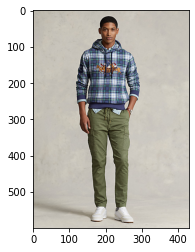

In [47]:
imshow(image)

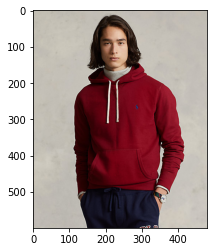

In [48]:
imshow(image2)

In [49]:
transform = albu.Compose([albu.Normalize(p=1)], p=1)

padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

with torch.no_grad():
  prediction = model(x)[0][0]

In [50]:
mask = (prediction > 0).cpu().numpy().astype(np.uint8)
mask = unpad(mask, pads)

In [51]:
padded_image2, pads = pad(image2, factor=32, border=cv2.BORDER_CONSTANT)

x = transform(image=padded_image2)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

with torch.no_grad():
  prediction = model(x)[0][0]

In [52]:
mask2 = (prediction > 0).cpu().numpy().astype(np.uint8)
mask2 = unpad(mask2, pads)

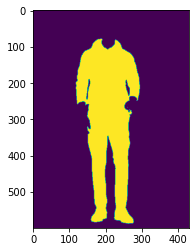

In [53]:
imshow(mask)

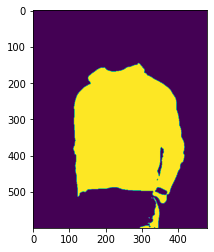

In [54]:
imshow(mask2)

In [55]:
def preprocess(cloth, cloth_mask):
  mask = cv2.cvtColor(cloth_mask, cv2.COLOR_GRAY2RGB)
  main_cloth = cloth * mask
  blue_back = ((cloth - main_cloth)*(0, 0, 255)).astype(np.uint8)
  blue_back[:, :, 2] = (blue_back[:, :, 2]/blue_back[:, :, 2]).copy()
  blue_back = blue_back*255
  blue_background_cloth = cv2.addWeighted(blue_back, 1, main_cloth, 1, 0)
  return blue_background_cloth

In [56]:
result = preprocess(image, mask)

<ipython-input-55-c6001d307f5d>:5: RuntimeWarning: invalid value encountered in true_divide
  blue_back[:, :, 2] = (blue_back[:, :, 2]/blue_back[:, :, 2]).copy()


In [57]:
result2 = preprocess(image2, mask2)

<ipython-input-55-c6001d307f5d>:5: RuntimeWarning: invalid value encountered in true_divide
  blue_back[:, :, 2] = (blue_back[:, :, 2]/blue_back[:, :, 2]).copy()


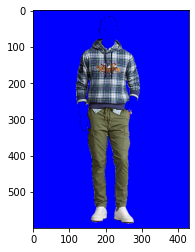

In [58]:
imshow(result)

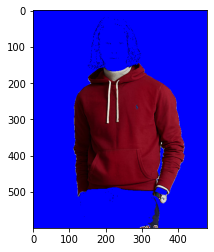

In [59]:
imshow(result2)